In [801]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image
import cv2

In [802]:
def intrinsics(fx, fy, cx, cy, s):
    # Define the camera intrinsic matrix
    K = np.array([[fx, s, cx],
                  [0, fy, cy],
                  [0,  0, 1 ]])
    print('The intrinsic Matrix is: \n', K )

    return K

In [803]:
def extrinsic(R,t):
  
    Rt = np.hstack((R, t))
    print('The Extrinsic Matrix is: \n',Rt)
    return Rt

In [804]:
def propogation(K,Rt):
    P=K @ Rt
 
    return P

In [805]:
def compute_directions(K, pts):
    """
    Compute direction vectors from the camera center to the points.
    
    Parameters:
    - K: Intrinsic camera matrix
    - pts: 2D points in the image plane (N x 2 or N x 3)

    Returns:
    - directions: Normalized direction vectors (N x 3)
    """
    # Check if points are in homogeneous coordinates (3D)
    if pts.shape[1] == 3:
        pts_h = pts  # Points are already in homogeneous coordinates
    else:
        # Convert 2D points (u, v) to homogeneous coordinates (u, v, 1)
        pts_h = np.hstack([pts, np.ones((pts.shape[0], 1))])

    # Compute inverse of the intrinsic matrix
    K_inv = np.linalg.inv(K)
    
    # Compute direction vectors by multiplying with K_inv
    directions = pts_h @ K_inv.T

    # Normalize the direction vectors to have unit length
    norms = np.linalg.norm(directions, axis=1).reshape(-1, 1)
    directions_normalized = directions / norms
    
    return directions_normalized


In [806]:
def plot_camera_directions(camera1_center, camera2_center, directions_camera1, directions_camera2):
    """
    Visualize the camera centers and direction vectors for corresponding points.

    Parameters:
    - camera1_center: Coordinates of the first camera center (3D vector).
    - camera2_center: Coordinates of the second camera center (3D vector).
    - directions_camera1: List of direction vectors from the first camera (N x 3 array).
    - directions_camera2: List of direction vectors from the second camera (N x 3 array).
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot camera centers
    ax.scatter(*camera1_center, color='red', s=100, label='Camera 1 Center')
    ax.scatter(*camera2_center, color='blue', s=100, label='Camera 2 Center')

    # Number of points (assuming directions_camera1 and directions_camera2 have the same length)
    num_points = len(directions_camera1)

    # Plot direction vectors from Camera 1
    for i in range(num_points):
        color = np.random.rand(3,)  # Random color for each corresponding point
        ax.quiver(*camera1_center, *directions_camera1[i], color=color, length=5, normalize=True)
        ax.quiver(*camera2_center, *directions_camera2[i], color=color, length=5, normalize=True)

    # Setting the plot labels and limits
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    ax.set_title('Camera Centers and Direction Vectors')
    
    plt.show()

In [807]:
def triangulate_point(P1, P2, x1, x2):
    """
    Perform triangulation to find the 3D point corresponding to a pair of 2D points.

    Parameters:
    - P1: Projection matrix of the first camera (3x4 matrix).
    - P2: Projection matrix of the second camera (3x4 matrix).
    - x1: 2D point in the first image (homogeneous coordinates [u, v, 1]).
    - x2: 2D point in the second image (homogeneous coordinates [u, v, 1]).

    Returns:
    - X: Triangulated 3D point (homogeneous coordinates [X, Y, Z, 1]).
    """
    # Construct the system of linear equations
    A = np.array([
        x1[0] * P1[2, :] - P1[0, :],  # Equation for x1
        x1[1] * P1[2, :] - P1[1, :],  # Equation for y1
        x2[0] * P2[2, :] - P2[0, :],  # Equation for x2
        x2[1] * P2[2, :] - P2[1, :]   # Equation for y2
    ])

    # Solve using SVD (least squares solution)
    _, _, V = np.linalg.svd(A)
    X = V[-1]
    
    # Normalize the point (homogeneous coordinates)
    X = X / X[-1]

    return X

In [808]:
def triangulate_points(P1, P2, points1, points2):
    """
    Perform triangulation for a set of corresponding points.

    Parameters:
    - P1: Projection matrix of the first camera.
    - P2: Projection matrix of the second camera.
    - points1: List of 2D points from the first camera (Nx3 array in homogeneous coordinates).
    - points2: List of 2D points from the second camera (Nx3 array in homogeneous coordinates).

    Returns:
    - X: Nx4 array of triangulated 3D points (in homogeneous coordinates).
    """
    num_points = points1.shape[0]

    X = np.zeros((num_points, 4))  # 4 for homogeneous coordinates

    for i in range(num_points):
        X[i] = triangulate_point(P1, P2, points1[i], points2[i])

    return X

In [809]:
def triangulate_points_cmd(P1, P2, pts1, pts2):
    """
    Triangulate 3D points from corresponding 2D points using OpenCV's triangulatePoints.
    
    Parameters:
    - P1: Camera projection matrix for the first view (3x4).
    - P2: Camera projection matrix for the second view (3x4).
    - pts1: 2D points in the first image (Nx2).
    - pts2: 2D points in the second image (Nx2).

    Returns:
    - 3D points (Nx3) in Euclidean coordinates.
    """
    # Make sure the points are in (Nx2) format
    if pts1.shape[1] == 3:
        pts1 = pts1[:, :2]
    if pts2.shape[1] == 3:
        pts2 = pts2[:, :2]

    # Perform triangulation using OpenCV
    points_4d_homogeneous = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    
    # Convert from homogeneous to Euclidean coordinates
    points_3d = points_4d_homogeneous[:3, :] / points_4d_homogeneous[3, :]
    
    return points_3d.T

In [810]:
def plot_camera_directions_with_3d_points(camera1_center, camera2_center, directions_camera1, directions_camera2,  points_3d):
    """
    Visualize the camera centers, direction vectors, and triangulated 3D points with the same colors.

    Parameters:
    - camera1_center: Coordinates of the first camera center (3D vector).
    - camera2_center: Coordinates of the second camera center (3D vector).
    - directions_camera1: List of direction vectors from the first camera (N x 3 array).
    - directions_camera2: List of direction vectors from the second camera (N x 3 array).
    - ray_length: Length of the direction vectors (rays) to be plotted.
    - points_3d: List of triangulated 3D points (N x 3 array).
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot camera centers
    ax.scatter(*camera1_center, color='red', s=100, label='Camera 1 Center')
    ax.scatter(*camera2_center, color='blue', s=100, label='Camera 2 Center')

    # Number of points
    num_points = len(directions_camera1)

    # Plot direction vectors from Camera 1 and Camera 2 and corresponding 3D points
    for i in range(num_points):
        color = np.random.rand(3,)  # Generate the same random color for both rays and the point
        direction1 = directions_camera1[i] / np.linalg.norm(directions_camera1[i])
        direction2 = directions_camera2[i] / np.linalg.norm(directions_camera2[i])
        
        # Scale the direction vectors by ray_length
        ax.quiver(*camera1_center, *(direction1), color=color, length=50, normalize=False)
        ax.quiver(*camera2_center, *(direction2), color=color, length=50, normalize=False)
        
        # Plot 3D point with the same color
        ax.scatter(points_3d[i, 0], points_3d[i, 1], points_3d[i, 2], color=color, s=50)

    # Setting the plot labels and limits
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.legend()
    ax.set_title(' Triangulated 3D Points')
    
    plt.show()

In [811]:
def project_points(P, points_3d):
    """
    Project 3D points onto the image plane using the camera projection matrix.

    Parameters:
    - P: Camera projection matrix (3x4).
    - points_3d: Array of 3D points in Cartesian coordinates (Nx3).

    Returns:
    - projected_points: Projected 2D points in homogeneous coordinates (Nx2).
    """
    # Convert 3D points to homogeneous coordinates (Nx4)
    points_3d_homogeneous = np.hstack([points_3d, np.ones((points_3d.shape[0], 1))])

    # Project points by multiplying projection matrix with 3D points
    projected_points_homogeneous = P @ points_3d_homogeneous.T  # (3x4) @ (4xN) = (3xN)
    
    # Convert from homogeneous to Cartesian coordinates by dividing by the third row
    projected_points_homogeneous = projected_points_homogeneous.T
    projected_points = projected_points_homogeneous[:, :2] / projected_points_homogeneous[:, 2, np.newaxis]
    
    return projected_points

In [812]:
c = 522
m = 0
s = 0
cx = 320
cy = 240
fx = c
fy = c * (1 + m)


In [813]:
R = np.array([[0.7201, -0.6648, 0.1988],
              [0.6533,  0.7461, 0.1286],
              [-0.2338, 0.0373, 0.9716]])
# Baseline
b = np.array([[59.5340], 
              [-39.2248],
              [1]])

The Extrinsic Matrix is: 
 [[ 7.20100e-01 -6.64800e-01  1.98800e-01  5.95340e+01]
 [ 6.53300e-01  7.46100e-01  1.28600e-01 -3.92248e+01]
 [-2.33800e-01  3.73000e-02  9.71600e-01  1.00000e+00]]
The intrinsic Matrix is: 
 [[522   0 320]
 [  0 522 240]
 [  0   0   1]]
Projection matrix of camera-1
[[522.   0. 320.   0.]
 [  0. 522. 240.   0.]
 [  0.   0.   1.   0.]]
Projection matrix of camera-2
[[ 3.01076200e+02 -3.35089600e+02  4.14685600e+02  3.13967480e+04]
 [ 2.84910600e+02  3.98416200e+02  3.00313200e+02 -2.02353456e+04]
 [-2.33800000e-01  3.73000000e-02  9.71600000e-01  1.00000000e+00]]
Triangulated 3D points by command:
[[ 3.87313017e+02 -3.37818002e-01 -5.07887012e+02]
 [-1.10956514e+02  1.07483519e+02  2.02229419e+02]
 [-3.29435848e+01  4.39481744e+01  9.39811822e+01]
 [-2.31783341e+01  3.81394708e+01  1.04999301e+02]
 [-1.35083335e+01  4.81353756e+01  8.47208013e+01]
 [-3.79504724e+01  6.70356518e+01  1.07511801e+02]
 [-5.79833777e+01  6.29367316e+01  1.30141816e+02]
 [-1.14554

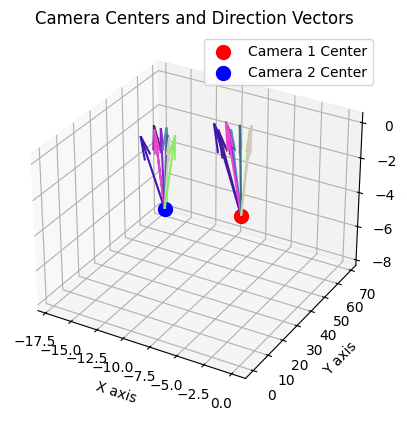

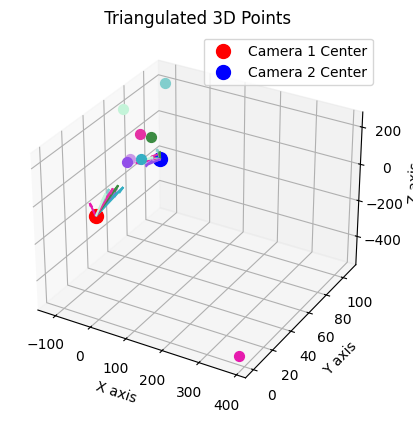

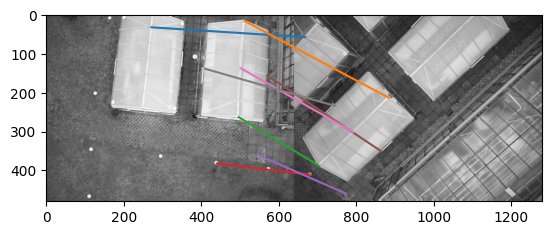

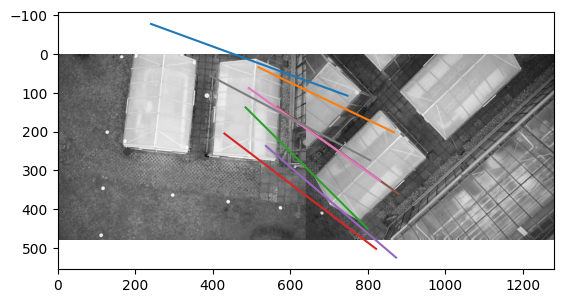

In [814]:
Rt=extrinsic(R,b)

k=intrinsics(fx, fy, cx, cy, s)

P1 = k@ np.hstack([np.eye(3), np.zeros((3, 1))])
print('Projection matrix of camera-1')
print(P1)
P2=propogation(k,Rt)
print('Projection matrix of camera-2')
print(P2)

pts1 = scipy.io.loadmat("U:\\Final Year Project\\FYP-2\\Tasks\\4. Triangulation\\4) Triangulation\\data\\x1x2.mat")["x1"]
pts2 = scipy.io.loadmat("U:\\Final Year Project\\FYP-2\\Tasks\\4. Triangulation\\4) Triangulation\\data\\x1x2.mat")["x2"]

img1 = matplotlib.image.imread("U:\\Final Year Project\\FYP-2\\Tasks\\4. Triangulation\\4) Triangulation\\data\\0400.jpg")
img2 = matplotlib.image.imread("U:\\Final Year Project\\FYP-2\\Tasks\\4. Triangulation\\4) Triangulation\\data\\0840.jpg")

directions_camera1 = compute_directions(k, pts1)
directions_camera2 = compute_directions(k, pts2)

# Triangulate 3D points
pts3D = np.array([triangulate_point(P1, P2, pts1[i], pts2[i]) for i in range(pts1.shape[0])])

cam1_center = np.array([0, 0, 0])  # Camera 1 center at origin
cam2_center = -R.T @ b  # Camera 2 center transformed back to world coordinates

points_3d = triangulate_points_cmd(P1, P2, pts1, pts2)
print("Triangulated 3D points by command:")
print(points_3d)

triangulated_points = triangulate_points(P1, P2, pts1, pts2)
print("Triangulated 3D points:")
print(triangulated_points)
triangulated_points_3d = triangulated_points[:, :3]  # Ignore the homogeneous coordinate for visualization
# plot_rays_and_intersections(cam1_center, cam2_center, pts3D, pts1, pts2)

# points_3d = triangulate_points(P1, P2, pts1, pts2)
# print('Triangulated 3D points:')
# print(points_3d)

points1_projected = project_points(P1, triangulated_points_3d)
points2_projected = project_points(P2, triangulated_points_3d)

plot_camera_directions(cam1_center, cam2_center, directions_camera1, directions_camera2)

plot_camera_directions_with_3d_points(cam1_center, cam2_center, directions_camera1, directions_camera2, triangulated_points)

I = np.hstack([img1,img2])
plt.figure()
plt.imshow(I,cmap='gray')
for i in range(pts1.shape[0]):
    plt.plot([pts1[i,1],pts2[i,1]+img1.shape[1]],[pts1[i,0],pts2[i,0]],'-')
plt.show()

Z = np.hstack([img1,img2])
plt.figure()
plt.imshow(Z,cmap='gray')
for i in range(points1_projected.shape[0]):
    plt.plot([points1_projected [i,1],points2_projected[i,1]+img1.shape[1]],[points1_projected[i,0],points2_projected[i,0]],'-')
plt.show()